In [7]:
from os import listdir, walk
from os.path import isfile, join
import numpy as np
from PIL import Image
import time
import cv2
from sys import getsizeof
from IPython.display import display
import random
import math
import datetime
import sys
from tensorflow.keras.optimizers import *
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#tf.config.optimizer.set_jit(True)
#tf.debugging.set_log_device_placement(True)
print(tf.config.experimental.list_physical_devices())

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
N_EPOCHS = 20
TRAIN_P = 0.8
VAL_P = 0.2
TEST_P = 0


%run ./variables.ipynb
%run ./utils.ipynb
%run ../utils/data_utils.ipynb

id_map = get_selected_taxons("../../selected_taxons.txt")
n_classes = len(list(id_map.keys()))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Handle data

In [75]:
X, y, _ = get_dataset()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = np.array(y_train).astype("uint8")
y_test = np.array(y_test).astype("uint8")
print("Original length:", len(X))
print("Test length:", len(X_train), "- n classes:", len(np.unique(y_train)))
print("Test length:", len(X_test), "- n classes:", len(np.unique(y_test)))
# Balance dataset
train_dict = {}
for file, label in zip(X_train, y_train):
    train_dict.setdefault(label, []).append(file)
max_samples = np.max([len(train_dict[taxon_id]) for taxon_id in train_dict])
X_train = []
y_train = []
for taxon_id in train_dict:
    ratio = np.ceil(max_samples/len(train_dict[taxon_id]))
    tmp = np.repeat(train_dict[taxon_id], ratio)
    np.random.shuffle(tmp)
    train_dict[taxon_id] = tmp[0:max_samples]
    X_train.extend(tmp[0:max_samples])
    y_train.extend([taxon_id]*max_samples)

'171/171'

Original length: 6144
Test length: 4915 - n classes: 171
Test length: 1229 - n classes: 167


In [76]:
data_train = {'png_path':  X_train, 'taxon_id': y_train}
data_test = {'png_path':  X_test, 'taxon_id': y_test}

In [77]:
df_train = pd.DataFrame(data_train, columns = ['png_path', 'taxon_id'])
df_test = pd.DataFrame(data_test, columns = ['png_path', 'taxon_id'])
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)

# Prtining some infos
print(len(df_train), len(df_test))
df_train.head()
df_test.head()

20691 1229


,png_path,taxon_id
0,/mnt/balrog/pfauregi/datasets/condensed/NDIS/I...,143
1,/mnt/balrog/pfauregi/datasets/condensed/FSLU/I...,92
2,/mnt/balrog/pfauregi/datasets/condensed/CMED/B...,40
3,/mnt/balrog/pfauregi/datasets/condensed/FLEN/I...,83
4,/mnt/balrog/pfauregi/datasets/condensed/GSCI/I...,108


In [78]:
datagen = ImageDataGenerator(rescale=1./255.,
                         rotation_range=90, 
                         brightness_range=[0.8,1.2], 
                         horizontal_flip=True, 
                         vertical_flip=True,
                         fill_mode='nearest',
                         width_shift_range=40,
                         height_shift_range=40,
                         zoom_range=0.2,
                         validation_split=0.2,
                         #featurewise_std_normalization=True,
                         data_format="channels_last") 
train_generator = datagen.flow_from_dataframe(
        dataframe=df_train,
        x_col='png_path',
        y_col='taxon_id',
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')
val_generator = datagen.flow_from_dataframe(
        dataframe=df_test,
        x_col='png_path',
        y_col='taxon_id',
        batch_size=32,
        class_mode='categorical')

TypeError: If class_mode="categorical", y_col="taxon_id" column values must be type string, list or tuple.

137


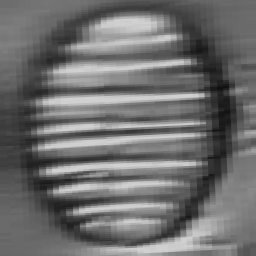

127


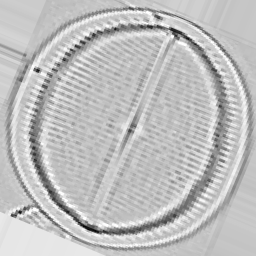

107


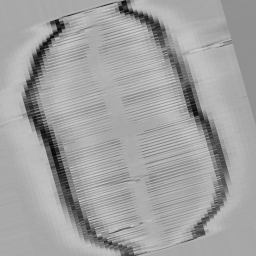

45


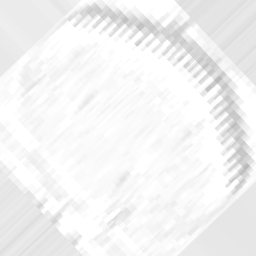

29


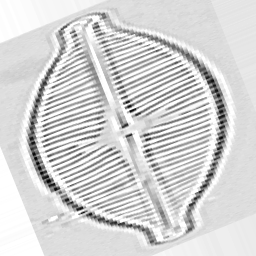

111


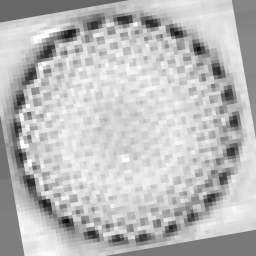

99


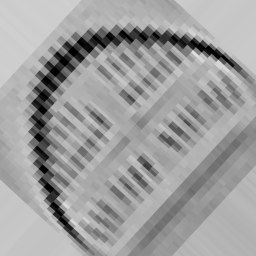

75


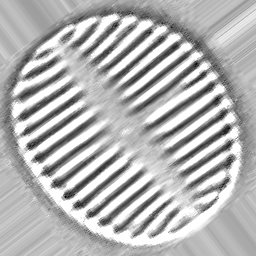

123


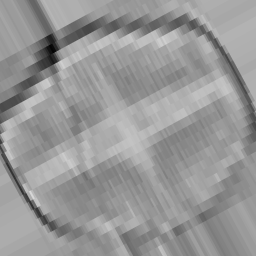

78


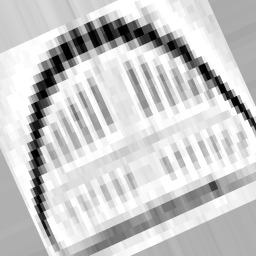

42


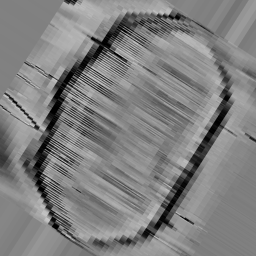

115


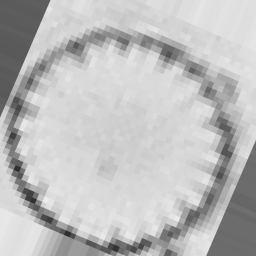

153


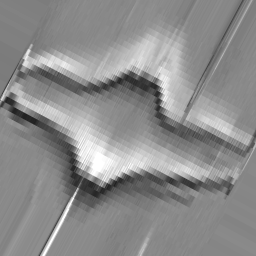

31


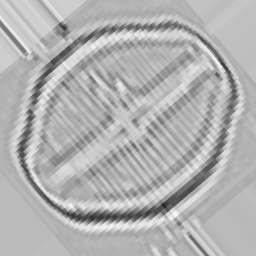

129


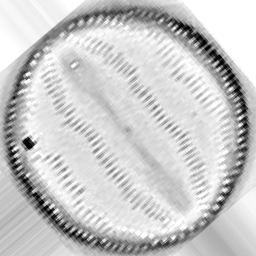

30


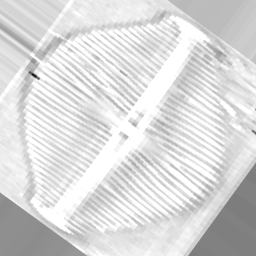

75


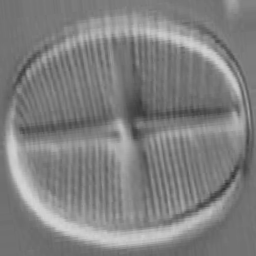

4


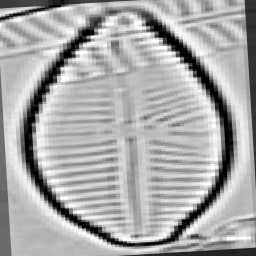

109


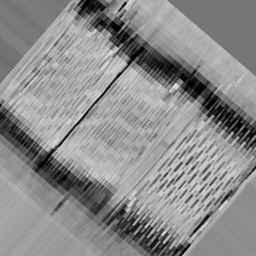

63


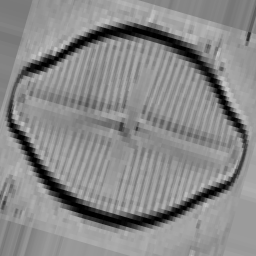

6


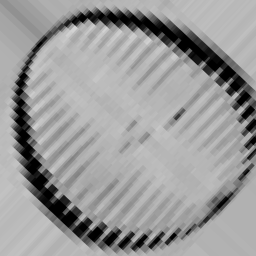

123


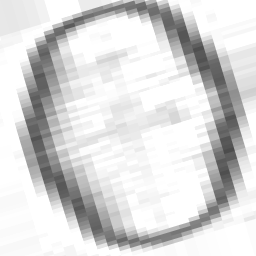

8


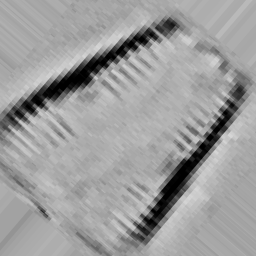

149


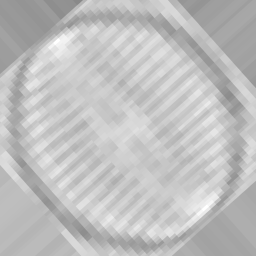

44


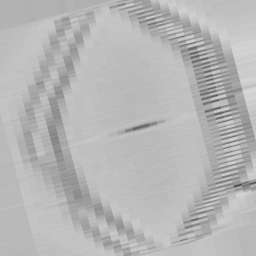

13


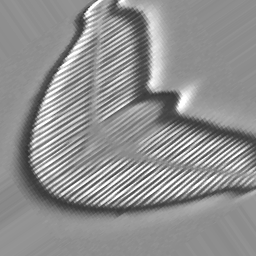

91


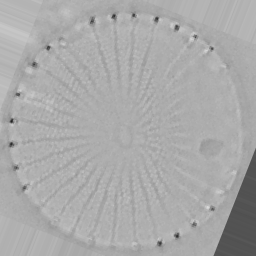

167


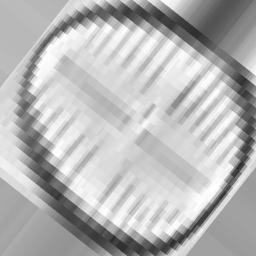

27


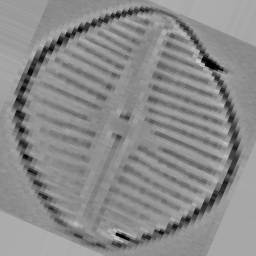

51


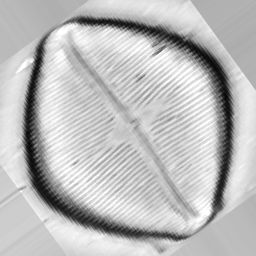

159


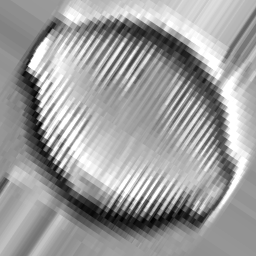

62


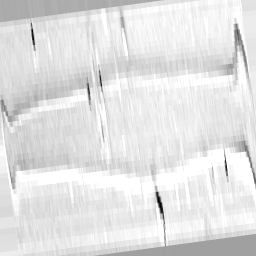

In [102]:
i = 0
for batch in train_generator:
    i+=1
    images = batch[0]
    labels = batch[1]
    for i in range(images.shape[0]):
        print(np.argmax(labels[i]))
        image = (images[i,:,:,:]*255).astype('uint8')
        #print(image)
        display(Image.fromarray(image))
    #display()
    if i>=1:
        break

# Model desgin

In [6]:
# fetching base model
#base_model = Xception(include_top=False, weights='imagenet', input_shape=(256, 256, 3), pooling=None)
input_tensor = Input(shape=(256, 256, 3))
base_model = InceptionV3(weights='imagenet', input_tensor=input_tensor, include_top=False)

In [7]:
# setting model for specifiv case
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
out = Dense(230, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=out)

# Training

In [8]:
# Setting tensorboard
!rm -rf LOG_DIR
log_dir = LOG_DIR + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

## New layers only

In [9]:
print(int(0.1*N_EPOCHS), "epochs composed of", (int(train_size/BATCH_SIZE)-1), "batches (steps) of", BATCH_SIZE, "images.")

2 epochs composed of 923 batches (steps) of 32 images.


In [10]:
n_epochs_train1 = 3


train_train1 = train_dataset.repeat(n_epochs_train1).batch(BATCH_SIZE)
val_train1 = val_dataset.repeat(n_epochs_train1).batch(BATCH_SIZE)

for layer in base_model.layers:
    layer.trainable = False
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
model.fit(train_train1, 
          epochs=n_epochs_train1, 
          steps_per_epoch=int(train_size/BATCH_SIZE),
          use_multiprocessing=True, 
          validation_data=val_train1,
          validation_steps=int(val_size/BATCH_SIZE),
          callbacks=[tensorboard_callback],
          initial_epoch=0)

Train for 924 steps, validate for 231 steps
Epoch 1/3
924/924 [==============================] - 76s 83ms/step - loss: 2.8451 - accuracy: 0.3487 - val_loss: 4.2532 - val_accuracy: 0.1201
Epoch 2/3
924/924 [==============================] - 75s 81ms/step - loss: 1.4774 - accuracy: 0.5947 - val_loss: 4.8679 - val_accuracy: 0.1305
Epoch 3/3
924/924 [==============================] - 73s 79ms/step - loss: 1.1828 - accuracy: 0.6652 - val_loss: 5.4622 - val_accuracy: 0.1272


In [ ]:
train_train1 = train_dataset.repeat(n_epochs_train1).batch(BATCH_SIZE)
val_train1 = val_dataset.repeat(n_epochs_train1).batch(BATCH_SIZE)

print(n_epochs_train1*int(train_size/BATCH_SIZE))
print(tf.data.experimental.cardinality(train_train1).numpy())
print(n_epochs_train1*int(val_size/BATCH_SIZE))
print(int(tf.data.experimental.cardinality(val_train1).numpy()))
val_size

## Training 2 last inceptions blocks

In [ ]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

In [11]:
n_epochs_train2 = n_epochs_train1+10

train_train2 = train_dataset.repeat(n_epochs_train2).batch(BATCH_SIZE)
val_train2 = val_dataset.repeat(n_epochs_train2).batch(BATCH_SIZE)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit(train_train2, 
          epochs=n_epochs_train2, 
          steps_per_epoch=int(train_size/BATCH_SIZE)-1,
          use_multiprocessing=True, 
          validation_data=val_train2,
          validation_steps=int(val_size/BATCH_SIZE)-1,
          callbacks=[tensorboard_callback],
          initial_epoch=n_epochs_train1)

Train for 923 steps, validate for 230 steps
Epoch 4/13
923/923 [==============================] - 83s 90ms/step - loss: 0.9412 - accuracy: 0.7200 - val_loss: 3.8516 - val_accuracy: 0.2923
Epoch 5/13
923/923 [==============================] - 80s 87ms/step - loss: 0.4425 - accuracy: 0.8576 - val_loss: 3.9563 - val_accuracy: 0.2921
Epoch 6/13
923/923 [==============================] - 82s 89ms/step - loss: 0.3202 - accuracy: 0.8966 - val_loss: 4.5561 - val_accuracy: 0.2745
Epoch 7/13
923/923 [==============================] - 82s 88ms/step - loss: 0.2618 - accuracy: 0.9153 - val_loss: 4.7518 - val_accuracy: 0.2973
Epoch 8/13
923/923 [==============================] - 83s 89ms/step - loss: 0.2224 - accuracy: 0.9260 - val_loss: 5.0559 - val_accuracy: 0.2894
Epoch 9/13
923/923 [==============================] - 82s 89ms/step - loss: 0.1874 - accuracy: 0.9361 - val_loss: 4.1446 - val_accuracy: 0.3476
Epoch 10/13
923/923 [==============================] - 82s 88ms/step - loss: 0.1659 - accura

## Training full model

In [12]:
n_epochs_train3 = n_epochs_train2+20

train_train3 = train_dataset.repeat(n_epochs_train3).batch(BATCH_SIZE)
val_train3 = val_dataset.repeat(n_epochs_train3).batch(BATCH_SIZE)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit(train_train3, 
          epochs=n_epochs_train3, 
          steps_per_epoch=int(train_size/BATCH_SIZE)-1,
          use_multiprocessing=True, 
          validation_data=val_train3,
          validation_steps=int(val_size/BATCH_SIZE)-1,
          callbacks=[tensorboard_callback],
          initial_epoch=n_epochs_train2)

Train for 923 steps, validate for 230 steps
Epoch 14/33
923/923 [==============================] - 155s 168ms/step - loss: 0.7994 - accuracy: 0.7686 - val_loss: 0.5006 - val_accuracy: 0.8414
Epoch 15/33
923/923 [==============================] - 148s 161ms/step - loss: 0.3591 - accuracy: 0.8835 - val_loss: 0.6138 - val_accuracy: 0.8069
Epoch 16/33
923/923 [==============================] - 149s 161ms/step - loss: 0.2694 - accuracy: 0.9124 - val_loss: 0.2737 - val_accuracy: 0.9087
Epoch 17/33
923/923 [==============================] - 149s 162ms/step - loss: 0.2250 - accuracy: 0.9268 - val_loss: 1.2448 - val_accuracy: 0.7073
Epoch 18/33
923/923 [==============================] - 149s 162ms/step - loss: 0.1946 - accuracy: 0.9356 - val_loss: 0.3018 - val_accuracy: 0.9049
Epoch 19/33
923/923 [==============================] - 149s 162ms/step - loss: 0.1636 - accuracy: 0.9486 - val_loss: 0.3730 - val_accuracy: 0.8852
Epoch 20/33
923/923 [==============================] - 149s 162ms/step - l

## Saving model

In [13]:
model_json = model.save_weights("./saved_models/model.h5")
model_json = model.to_json()
with open("./saved_models/model.json", "w") as json_file:
    json_file.write(model_json)
    
    # serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

# Analytics

In [ ]:
preds = model.predict(test_dataset, use_multiprocessing=True)

In [ ]:
labels = [np.argmax(pred) for pred in preds]

In [ ]:
int(0.1*N_EPOCHS)

In [ ]:
labels